
# Project: Investigate Movie Database (TMDb)
                                                    by WH Liang, 2019/10/2
## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#lim"> Limitations</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

In this report we use the TMDb data set which contains information about 10,000 movies collected from The Movie Database (TMDb).  
For fare comparison between each year, this report use the final two columns endingwith “_adj” show the budget and revenue of the associated movie in terms of 2010 dollars,accounting for inflation overtime.  

## Questions and plans
### Research Question 1:  What are the number of appearance of each genres?
Plan:
Use bar chart to show the result.
### Research Question 2: Which genres are most popular from year to year?   
Plan:  
1.Calculate average "popularity values for each genres every year.  
2.Find the largest "popularity" value in each year and get the genre name.  
3.Choose a scatter chart to visualize the result.
### Research Question 3: What kinds of properties are associated with movies that have high revenues?  
Plan:  
1.Abstract the rows which have "high revenues" as in a range of 3rd quartile to maximum with 5 number summary.  
2.Perform Multiple Linear Regresson and check VIF of each independant values.  
3.Repeat step2 as above.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import seaborn as sb
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

In [2]:
df = pd.read_csv('./tmdb-movies.csv') 
df.head(1)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09


There are 21 columns and missing data in several columns.

Delete missing data, duplicated rows and non-need columns.  
Drop these columns because we don't need it for numeric data analysis in this project.

In [3]:
df.columns
df1 = df.drop(['id', 'imdb_id', 'budget','revenue','original_title','cast', 'homepage', 'director', 'tagline', 'keywords', 'overview','production_companies', 'release_date'], axis=1)
#check
df1.columns

Index(['popularity', 'runtime', 'genres', 'vote_count', 'vote_average',
       'release_year', 'budget_adj', 'revenue_adj'],
      dtype='object')

In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 8 columns):
popularity      10866 non-null float64
runtime         10866 non-null int64
genres          10843 non-null object
vote_count      10866 non-null int64
vote_average    10866 non-null float64
release_year    10866 non-null int64
budget_adj      10866 non-null float64
revenue_adj     10866 non-null float64
dtypes: float64(4), int64(3), object(1)
memory usage: 679.2+ KB


 These missing data in column 'genres' should not filled by any "not-real"values.  
 Drop these missing data in this report instead of fill it.

In [5]:
df1.dropna(axis=0,inplace=True)
df1.isnull().sum()

popularity      0
runtime         0
genres          0
vote_count      0
vote_average    0
release_year    0
budget_adj      0
revenue_adj     0
dtype: int64

In [6]:
sum(df1.duplicated())

1

1 row was duplicated.Drop the duplicated data and check again.

In [7]:

df1.drop_duplicates(inplace=True)
sum(df1.duplicated())

0

In [8]:
df1.shape

(10842, 8)

Separate data from multiplevalues separated by pipe (|)characters in 'genres' column.

In [9]:
hb = df1[df1['genres'].str.contains('\|')];
df1.drop(hb.index,inplace=True)
#Reset index to avoid key error after this,because some of index number disapeared
#print(df1.loc[423:])
hb = hb.reset_index(drop=True)
df1.shape

(2328, 8)

Create a function to process one row from the original df_org and return a small new dataframe as result.  
This is important to speed up.  
If the function return a big dataframe which include upper rows information from the df_org, the program will take very long time to run.

In [10]:
def split_row(df_org,row_no,column_name):
    namelist = df_org[column_name][row_no].split("|")
    length= len(namelist)
    #copy the original row first
    df_buf=pd.DataFrame(data=df_org.loc[row_no:row_no])
    for i in range(length):
        if i>0:
            df_buf = df_buf.append(df_org.loc[row_no:row_no],ignore_index = True)
    df_buf[column_name]= namelist
    return df_buf

Seperate all of the data from hybrid rows (hb) includes pipe (|)characters in 'genres' column.

In [11]:
#create a 0 length dataframe to contain the result
hb2 = pd.DataFrame(columns=hb.columns);
#To confirm how many rows are needed to process
print(hb.index.size)
for i in range(hb.index.size):
    hb2 = hb2.append( split_row(hb,i,"genres"),ignore_index = True)
hb2.shape

8514


(24627, 8)

In [12]:
df_2 = df1.append(hb2,ignore_index = True)

In [13]:
print(df_2.shape)
#check if any '|' remain in the result dataframe
df_2[df_2['genres'].str.contains('\|')]

(26955, 8)


,popularity,runtime,genres,vote_count,vote_average,release_year,budget_adj,revenue_adj


<a id='eda'></a>
## Exploratory Data Analysis
### Research Question 1:  What are the number of appearance of each genres?

Text(0, 0.5, 'Number Of Appearance')

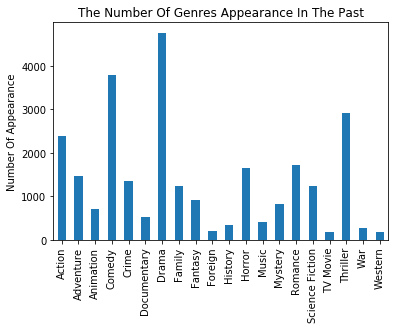

In [14]:
ax = df_2.groupby("genres")["popularity"].count().plot(kind="bar",title = "The Number Of Genres Appearance In The Past")
ax.set_xlabel("")
ax.set_ylabel("Number Of Appearance")

The most appeared genre is "Drama",2nd is "Comedy",3rd is "Thriller".

### Research Question 2:  Which genres are most popular from year to year?  

Calculate average "popularity values for each genres every year.

In [15]:
year_genre_mean = df_2.groupby(['release_year','genres'])["popularity"].mean()
year_genre_mean=year_genre_mean.reset_index()

In [16]:
year_genre_mean.head()

,release_year,genres,popularity
0,1960,Action,0.590724
1,1960,Adventure,0.700981
2,1960,Comedy,0.396000
3,1960,Crime,0.346480
4,1960,Drama,0.566305


Find the largest "popularity" value in each year and get the genre name.

In [17]:
list_max_popularity = year_genre_mean.groupby('release_year')["popularity"].max()
result = pd.DataFrame(columns = year_genre_mean.columns)
for i in range(list_max_popularity.shape[0]):
    result = result.append(year_genre_mean.query('popularity == {}'.format(list_max_popularity.iloc[i])))
result.head(3)

,release_year,genres,popularity
13,1960,Thriller,0.811910
18,1961,Animation,2.631987
34,1962,Adventure,0.942513


Choose a scatter chart because this is a categorical number.

Text(0.5, 0, 'Years')

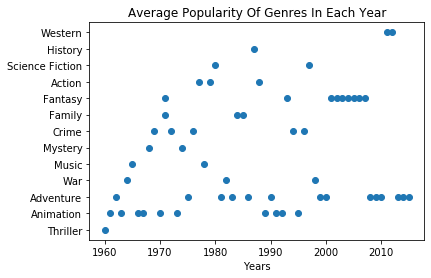

In [18]:
plt.scatter(result["release_year"], result["genres"]);
plt.title("Average Popularity Of Genres In Each Year")
plt.xlabel("Years")

We can see until around 1970, the most popular genre of each year was various.  
From around 1970 to around 2000, the most popular genre of each year become focused on few genres.  
Some genres are not the most popular in a year anymore like "Music","Mystery","Family" etc.  
From around 2000 and in 7 years continuously, the most popular genre of each year focoused in "Fantasy",but after that it changed to "Adventure" and "Western".

### Research Question 3:  What kinds of properties are associated with movies that have high revenues?  

In [19]:
df_2.head(2)

,popularity,runtime,genres,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,4.566713,131,Action,2349,7.1,2015,1.379999e+08,6.277435e+08
1,4.564549,115,Comedy,1666,6.3,2015,6.255997e+07,1.985944e+08


Define the "high revenues" as in a range of 3rd quartile to maximum with 5 number summary.

In [20]:
high_rev = df_2.query('revenue_adj >={}'.format(np.percentile(df_2["revenue_adj"],75)))
high_rev.head(2)

,popularity,runtime,genres,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,4.566713,131,Action,2349,7.1,2015,1.379999e+08,6.277435e+08
1,4.564549,115,Comedy,1666,6.3,2015,6.255997e+07,1.985944e+08


### Multiple Linear Regresson with VIF  
Create a new dataframe to do the analysis and keep the original dataframe for check. 

In [21]:
df_3 = df_2.copy()
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26955 entries, 0 to 26954
Data columns (total 8 columns):
popularity      26955 non-null float64
runtime         26955 non-null object
genres          26955 non-null object
vote_count      26955 non-null object
vote_average    26955 non-null float64
release_year    26955 non-null object
budget_adj      26955 non-null float64
revenue_adj     26955 non-null float64
dtypes: float64(4), object(4)
memory usage: 1.6+ MB


Some column values with non-numeric data.  
Change type of data to float type and check it.

In [22]:
df_3[['vote_count','release_year','runtime']] = df_3[['vote_count','release_year','runtime']].astype(float)
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26955 entries, 0 to 26954
Data columns (total 8 columns):
popularity      26955 non-null float64
runtime         26955 non-null float64
genres          26955 non-null object
vote_count      26955 non-null float64
vote_average    26955 non-null float64
release_year    26955 non-null float64
budget_adj      26955 non-null float64
revenue_adj     26955 non-null float64
dtypes: float64(7), object(1)
memory usage: 1.6+ MB


Before start Multiple Linear Regresson, see the correlation between each columns data.

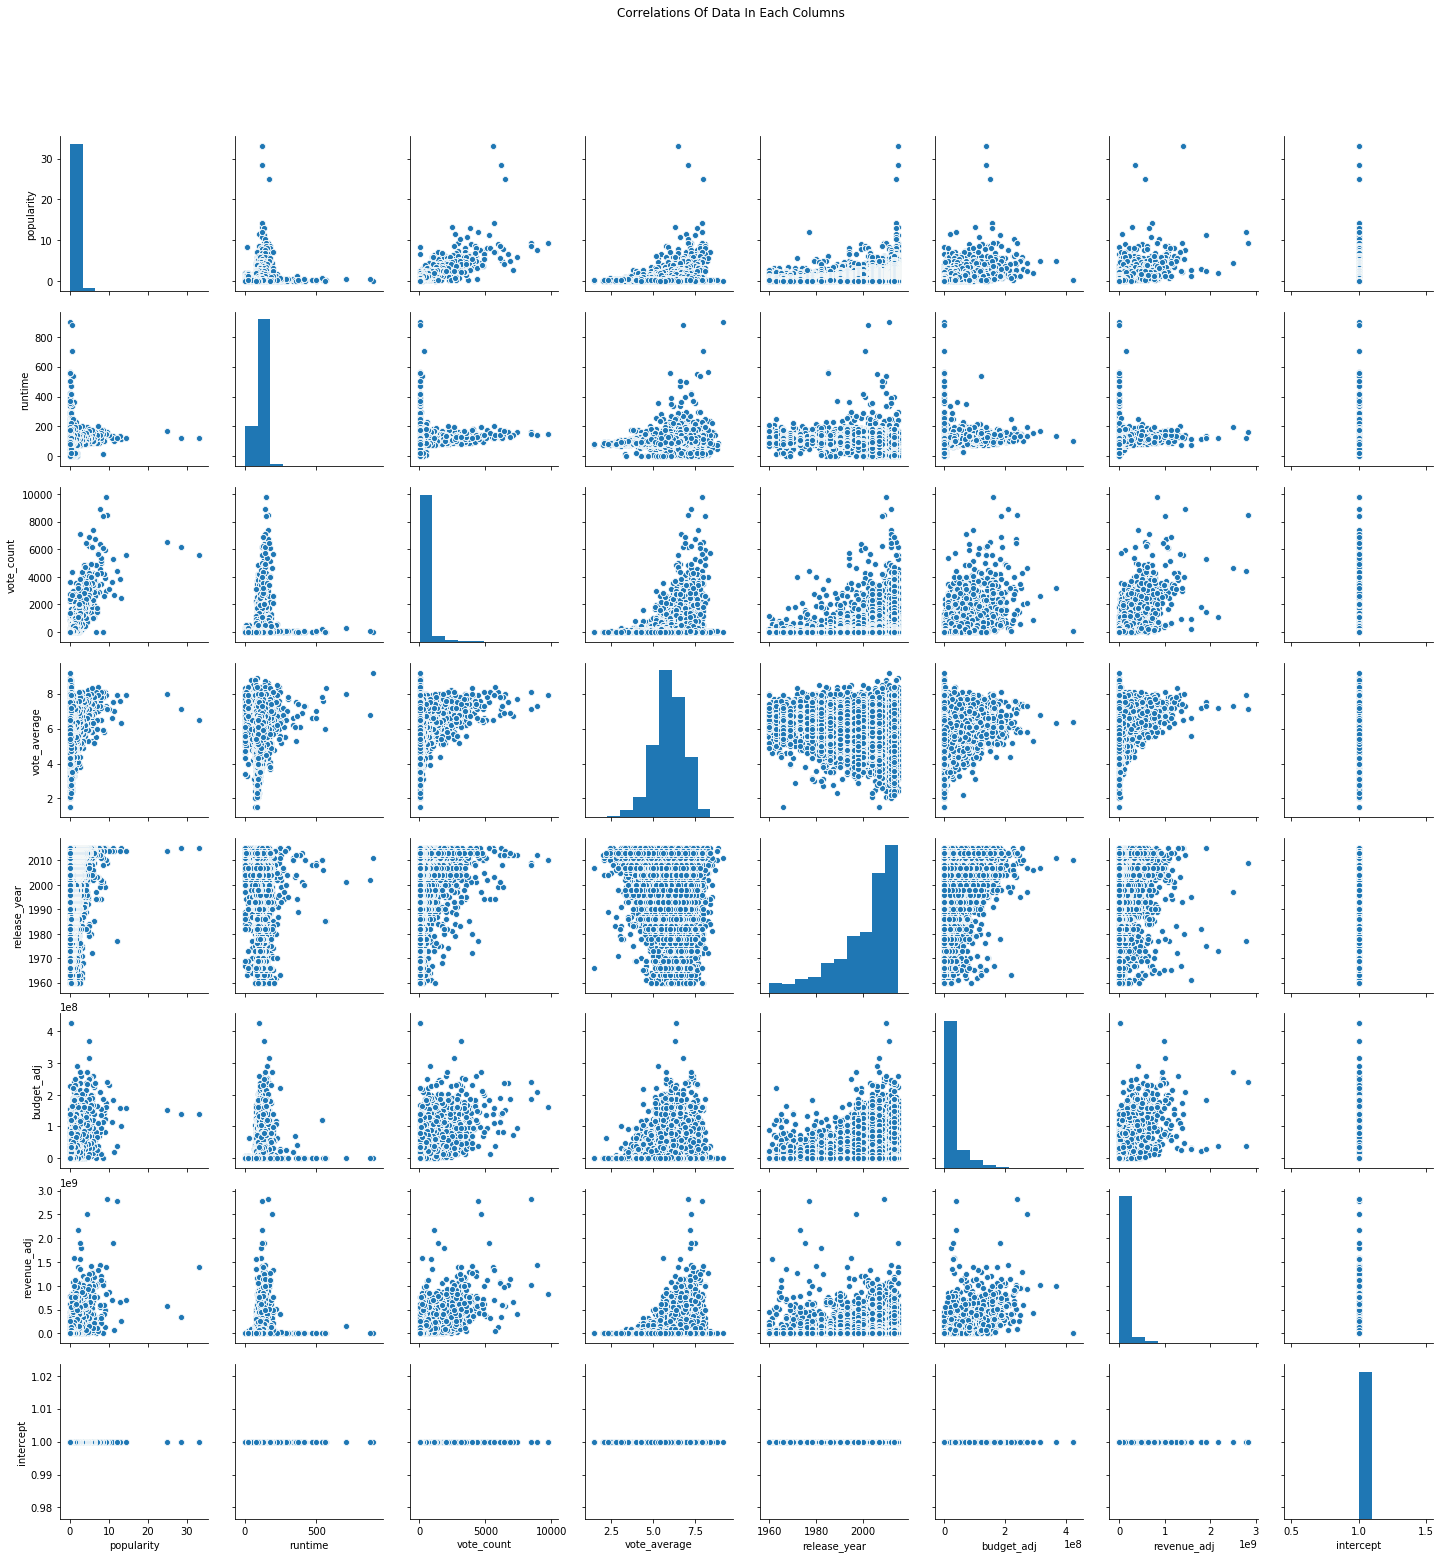

In [38]:
g = sb.pairplot(df_3);
g.fig.suptitle("Correlations Of Data In Each Columns", y=1.08);

In [24]:
df_3.head()

,popularity,runtime,genres,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,4.566713,131.0,Action,2349.0,7.1,2015.0,1.379999e+08,6.277435e+08
1,4.564549,115.0,Comedy,1666.0,6.3,2015.0,6.255997e+07,1.985944e+08
2,2.814802,121.0,Comedy,1255.0,7.1,2015.0,3.219999e+07,1.789994e+08
3,2.584264,100.0,Drama,631.0,6.3,2015.0,1.839999e+07,3.367819e+07
4,2.557859,120.0,Drama,867.0,7.3,2015.0,1.379999e+07,5.905618e+07


In [25]:
df_3.corr()

,popularity,runtime,vote_count,vote_average,release_year,budget_adj,revenue_adj
popularity,1.000000,0.142398,0.794882,0.233379,0.110153,0.507485,0.610301
runtime,0.142398,1.000000,0.174363,0.158572,-0.135148,0.235284,0.186991
vote_count,0.794882,0.174363,1.000000,0.279316,0.131383,0.593953,0.715001
vote_average,0.233379,0.158572,0.279316,1.000000,-0.125364,0.114075,0.216712
release_year,0.110153,-0.135148,0.131383,-0.125364,1.000000,0.042550,-0.047433
budget_adj,0.507485,0.235284,0.593953,0.114075,0.042550,1.000000,0.643496
revenue_adj,0.610301,0.186991,0.715001,0.216712,-0.047433,0.643496,1.000000


1.There is 3 values have large correlation between "revenue_adj". "popularity","vote_count","budget_adj" and these 3 values have strong correlation between each other. Choose "vote_count" in this report because it has the largest correlation between "revenue_adj".

In [26]:
y,X=dmatrices('revenue_adj ~ runtime + vote_count + vote_average',df_3,return_type = 'dataframe')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,52.695521,Intercept
1,1.045473,runtime
2,1.105427,vote_count
3,1.099466,vote_average


Non of VIF Factor is >10, so keep all of these variables.

In [27]:
df_3["intercept"]=float(1)
lm = sm.OLS(df_3["revenue_adj"],df_3[['intercept','runtime','vote_count','vote_average']])
results=lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            revenue_adj   R-squared:                       0.515
Model:                            OLS   Adj. R-squared:                  0.515
Method:                 Least Squares   F-statistic:                     9552.
Date:                Thu, 03 Oct 2019   Prob (F-statistic):               0.00
Time:                        06:11:56   Log-Likelihood:            -5.3794e+05
No. Observations:               26955   AIC:                         1.076e+06
Df Residuals:                   26951   BIC:                         1.076e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept    -2.947e+07   4.97e+06     -5.927      0.000   -3.92e+07   -1.97e+07
runtime       3.352e+05   2.31e+04     14.538      0.000     2.9e+05     3.8e+05
vote_count    1.775e+05   1128.796    157.216      0.000    1.75e+05     1.8e+05
vote_average  1.936e+06   7.88e+05      2.458      0.014    3.92e+05    3.48e+06
==============================================================================
Omnibus:                    27516.210   Durbin-Watson:                   0.566
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4179136.555
Skew:                           4.742   Prob(JB):                         0.00
Kurtosis:                      63.258   Cond. No.                     5.03e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.03e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

There is a warning of "condition number is large". The correlation between "vote_count" and "vote_average" is r = 0.279316. It is not small enough when we consider the correlation between "vote_average" and "revenue_adj". r = 0.216712. 
And, correlation between "vote_average" and "revenue_adj" is smaller than correlation between "vote_count" and "revenue_adj".  
So keep "vote_count" and don't use "vote_average".  

In [28]:
lm = sm.OLS(df_3["revenue_adj"],df_3[['intercept','runtime','vote_count']])
results=lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            revenue_adj   R-squared:                       0.515
Model:                            OLS   Adj. R-squared:                  0.515
Method:                 Least Squares   F-statistic:                 1.432e+04
Date:                Thu, 03 Oct 2019   Prob (F-statistic):               0.00
Time:                        06:11:56   Log-Likelihood:            -5.3794e+05
No. Observations:               26955   AIC:                         1.076e+06
Df Residuals:                   26952   BIC:                         1.076e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -1.88e+07   2.42e+06     -7.762      0.000   -2.35e+07    -1.4e+07
runtime     3.418e+05   2.29e+04     14.924      0.000    2.97e+05    3.87e+05
vote_count  1.782e+05   1090.424    163.407      0.000    1.76e+05     1.8e+05
==============================================================================
Omnibus:                    27529.077   Durbin-Watson:                   0.564
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4188241.991
Skew:                           4.746   Prob(JB):                         0.00
Kurtosis:                      63.324   Cond. No.                     2.43e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.43e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

It still has warning.  
This mean, the correlation between "vote_count" and "runtime". r = 0.174363 is not small enough when we consider the correlation between "runtime" and "revenue_adj". r = 0.186991 
Don't use "runtime".

In [29]:
lm = sm.OLS(df_3["revenue_adj"],df_3[['intercept','vote_count']])
results=lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            revenue_adj   R-squared:                       0.511
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                 2.819e+04
Date:                Thu, 03 Oct 2019   Prob (F-statistic):               0.00
Time:                        06:11:57   Log-Likelihood:            -5.3805e+05
No. Observations:               26955   AIC:                         1.076e+06
Df Residuals:                   26953   BIC:                         1.076e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.563e+07   7.39e+05     21.163      0.000    1.42e+07    1.71e+07
vote_count   1.81e+05   1078.127    167.902      0.000    1.79e+05    1.83e+05
==============================================================================
Omnibus:                    27512.617   Durbin-Watson:                   0.559
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4129534.019
Skew:                           4.746   Prob(JB):                         0.00
Kurtosis:                      62.889   Cond. No.                         736.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

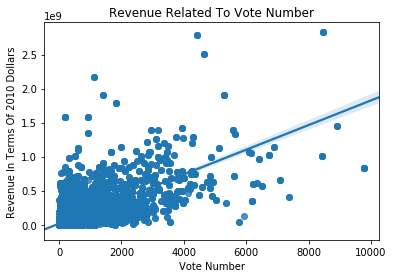

In [36]:
ax = sb.regplot(x='vote_count', y='revenue_adj', data=df_3);
ax.set_xlabel("Vote Number");
ax.set_ylabel("Revenue In Terms Of 2010 Dollars");
ax.set_title("Revenue Related To Vote Number");

<a id='lim'></a>
# Limitations

1.The data includes missing data and duplicated data.  
2.Some of the numeric data was string type, I need to change them to float type before analysis.  
3.I need to separate data from multiplevalues separated by pipe (|)characters in 'genres' column.
4.When I make a function to separate data from 'genres' column, I need to handle a large size of rows.In the first time, I could not get result because the function processed the whole dataframe which includes all information from the df_org and the process can't finish in 5 minutes. After many try, I revised the function to process only one row from the original df_org and return a small new dataframe as result.  


<a id='conclusions'></a>
## Conclusions
 
### With question 1:Which genres are most popular from year to year?
 The most popular genre of each year was various until around 1970.  
 From around 1970 to around 2000, it become focused on few genres and some genres are disapeard like "Music","Mystery","Family" etc.  
 From around 2000 and in 7 years continuously, it was "Fantasy",but after that it changed to "Adventure" and "Western".

### With question 2:  What kinds of properties are associated with movies that have high revenues?  

1).There is 3 values have large correlation between "revenue_adj". "popularity","vote_count","budget_adj" and these 3 values have strong correlation between each other.  
2). Choose "vote_count" value to perform Multiple Linear Regresson was sucsseed with very low p-value, but the R-squard value is 0.511 which means it is not match the model so much.  
3).limitation of this regresson is just include numeric data but didn't include categorical data like the "genres" value.
